In [167]:
import pandas as pd
import os
import numpy as np
import librosa.display
import IPython
import matplotlib.pyplot as plt
import librosa
from scipy.io.wavfile import read as read_wav
import seaborn as sns
import torchaudio
import torch.nn as nn

import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import torch
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

In [174]:
df = pd.read_csv("flattened_df.csv")
df.head()

,class,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,chroma_11,spectral_contrast_0,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,zero_crossing_rate_0,rms_0
0,0,-476.76318,151.93126,40.751000,32.728510,24.676027,-1.622958,-11.382446,-10.255580,-13.852532,...,0.068089,41.048962,26.657022,31.112326,26.683215,26.611419,19.727297,40.896356,0.024277,0.050103
1,0,-335.80048,179.62960,55.251270,31.447277,13.783207,6.018884,-1.724098,-9.665527,0.166537,...,0.428835,39.272528,23.480823,26.503096,25.982533,20.851178,20.883398,40.702037,0.019306,0.159007
2,0,-208.60654,157.71774,-48.672695,61.206535,2.445855,2.241497,-3.198201,1.449560,-3.622945,...,0.113615,36.368816,19.868934,20.128331,17.285692,16.384238,25.410261,46.935719,0.041716,0.119327
3,0,-171.53383,132.51572,-62.749226,48.265670,-15.114235,-4.501721,-10.768104,1.647050,-3.750773,...,0.911918,35.620444,20.570914,22.997742,23.478727,20.850390,27.112645,47.863388,0.105496,0.087741
4,0,-319.41586,170.46034,-26.558022,46.639340,6.880424,-0.927866,-14.999014,-35.355858,2.813988,...,0.438278,29.648201,23.275417,29.477784,26.782898,29.655154,30.428208,43.645725,0.040360,0.102849


In [182]:
# Separate features and labels
X = df.drop(columns=['class'])
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [183]:
class FCNN(nn.Module):
    def __init__(self, input_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x



In [185]:
# Instantiate the model
input_size = X_train.shape[1]
model = FCNN(input_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    
    # Evaluate the model on validation data
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch [1/50], Train Loss: 0.6905, Train Accuracy: 0.5112
Epoch [1/50], Val Loss: 0.6779, Val Accuracy: 0.6931
Epoch [2/50], Train Loss: 0.6599, Train Accuracy: 0.7357
Epoch [2/50], Val Loss: 0.6445, Val Accuracy: 0.7426
Epoch [3/50], Train Loss: 0.5993, Train Accuracy: 0.7805
Epoch [3/50], Val Loss: 0.5854, Val Accuracy: 0.7624
Epoch [4/50], Train Loss: 0.5202, Train Accuracy: 0.8030
Epoch [4/50], Val Loss: 0.4962, Val Accuracy: 0.8119
Epoch [5/50], Train Loss: 0.4239, Train Accuracy: 0.8279
Epoch [5/50], Val Loss: 0.4591, Val Accuracy: 0.8020
Epoch [6/50], Train Loss: 0.3806, Train Accuracy: 0.8429
Epoch [6/50], Val Loss: 0.4594, Val Accuracy: 0.8218
Epoch [7/50], Train Loss: 0.3532, Train Accuracy: 0.8529
Epoch [7/50], Val Loss: 0.4248, Val Accuracy: 0.8119
Epoch [8/50], Train Loss: 0.3097, Train Accuracy: 0.8728
Epoch [8/50], Val Loss: 0.4233, Val Accuracy: 0.8218
Epoch [9/50], Train Loss: 0.2732, Train Accuracy: 0.9027
Epoch [9/50], Val Loss: 0.3784, Val Accuracy: 0.8614
Epoch [10/

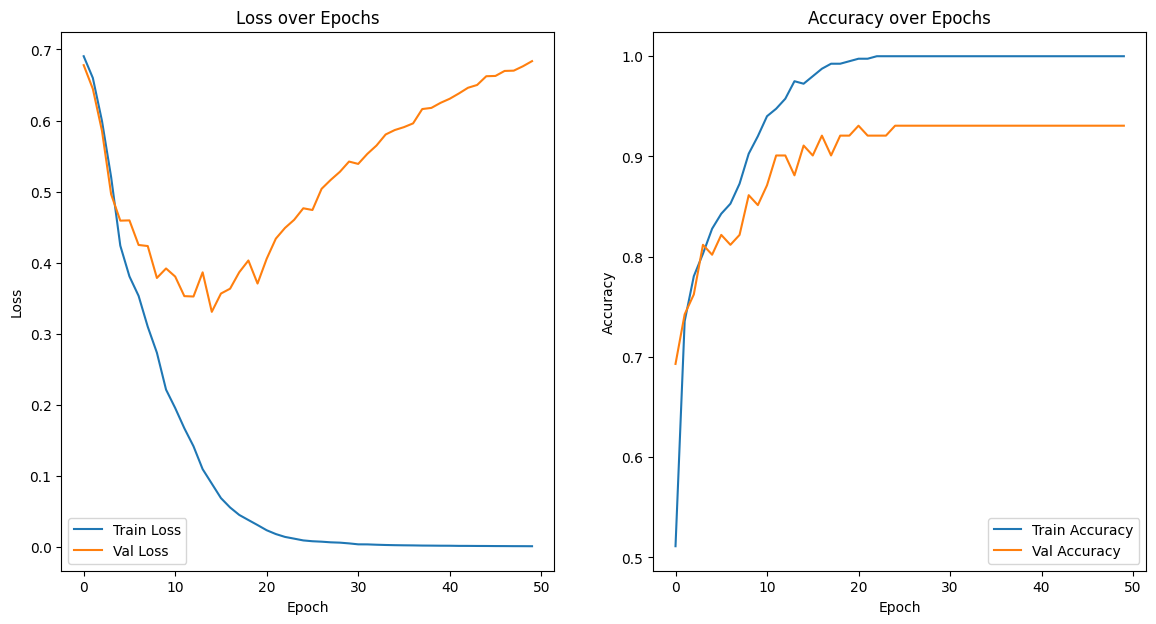

In [186]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(14, 7))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()